In [1]:
#setup

from constants import AMINO_ACID_INDICES, IMMUNOGENICITY_ONE_HOT
import numpy as np
from sklearn.decomposition import PCA
from Bio import pairwise2, SeqIO
import matplotlib.pyplot as plt
import seaborn as sns

trainpath = "C:/Users/micha/Downloads/spikeprot_train.txt"
validpath = "C:/Users/micha/Downloads/spikeprot_valid.txt"
testpath = "C:/Users/micha/Downloads/spikeprot_test.txt"

with open(trainpath) as f:
    train = f.read().splitlines()
with open(validpath) as f:
    valid = f.read().splitlines()
with open(testpath) as f:
    test = f.read().splitlines()

all_prot = []
all_prot.extend(train)
all_prot.extend(valid)
all_prot.extend(test)

del train
del valid
del test

all_prot_np = np.vstack(list(map(lambda x: np.array(list(x)),all_prot)))

all_prot = list(map(lambda x: x.replace("-", ""),all_prot))

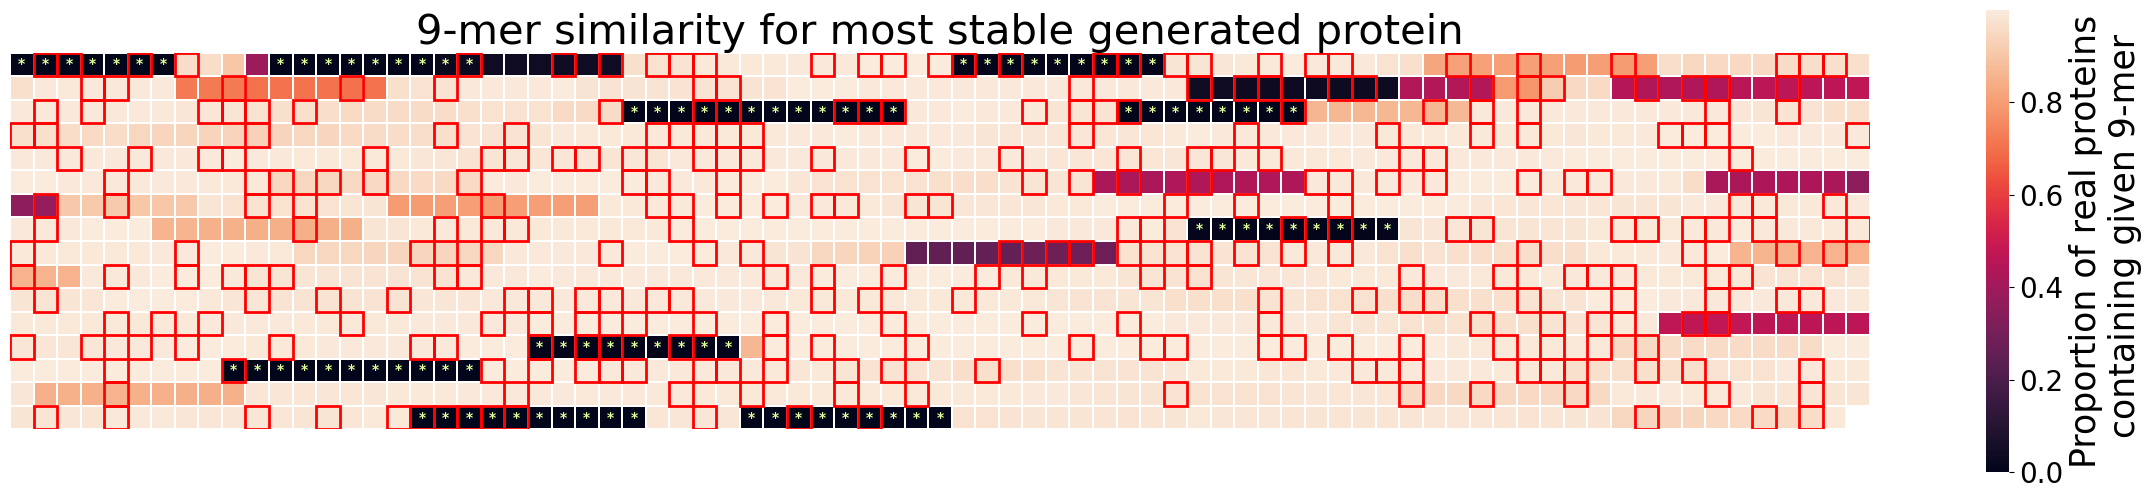

In [2]:
i = 4
stable_prot_to_eval = open(f"10 most stable\\{i}.fasta", "r").read() # protein to evaluate in fasta format
stable_prot_to_eval = stable_prot_to_eval.replace("\n","").split()[2][2:]
closest_natural = ""
maximum_alignment_score = float('-inf')
aligned_natural_seq = ''
aligned_synthetic_seq = ''
for natural_seq in all_prot:
    alignment_score = pairwise2.align.globalxs(stable_prot_to_eval,
                                                natural_seq,
                                                score_only=True,
                                                open=-1,
                                                extend=-0.1)

    if alignment_score > maximum_alignment_score:
        alignment = pairwise2.align.globalxs(stable_prot_to_eval,
                                                natural_seq,
                                                one_alignment_only=True,
                                                open=-1,
                                                extend=-0.1)
        maximum_alignment_score = alignment[0].score
        aligned_synthetic_seq = alignment[0].seqA
        aligned_natural_seq = alignment[0].seqB
    else:
        pass

aligned_natural_seq = aligned_natural_seq.replace("-","")
aligned_synthetic_seq = aligned_synthetic_seq.replace("-","")
nine_mers_nat = [aligned_natural_seq[i: i+9] for i in range(len(aligned_natural_seq)-8)]
nine_mers_syn = [aligned_synthetic_seq[i: i+9] for i in range(len(aligned_synthetic_seq)-8)]
novel_9mers = sorted(set(nine_mers_syn) - set(nine_mers_nat), key=nine_mers_syn.index)
prob_of_9_mers_novel = []
for nine_mer in novel_9mers:
    number_of_proteins_containg_ninemer = 0
    for prot in all_prot:
        if nine_mer in prot:
            number_of_proteins_containg_ninemer += 1
    prob_of_9_mers_novel.append(number_of_proteins_containg_ninemer/len(all_prot))
prob_of_9_mers_novel = np.array(prob_of_9_mers_novel)


nine_mers = [stable_prot_to_eval[i: i+9] for i in range(len(stable_prot_to_eval)-8)]
prob_of_9_mers = []
for nine_mer in nine_mers:
    number_of_proteins_containg_ninemer = 0
    for prot in all_prot:
        if nine_mer in prot:
            number_of_proteins_containg_ninemer += 1
    prob_of_9_mers.append(number_of_proteins_containg_ninemer/len(all_prot))

res = np.hstack([np.array(prob_of_9_mers),np.repeat(-1,79-len(prob_of_9_mers)%79)])
res = res.reshape(len(res)//79,79)
fig = plt.figure(figsize=(30, 6))
ax = sns.heatmap(res, linewidth=0.01, square=True, cbar_kws={'label': 'Proportion of real proteins\n containing given 9-mer'},mask=(res==-1))
ax.figure.axes[-1].yaxis.label.set_size(25)

places = np.load(f"C:/Users/micha/Downloads/NetMHCpan10prot/NetMHCpan10prot/{i}_binder_track.npy") # binary vector indicating mhcpan hit for each nine-mer

a=b=0
for j in places:
    if j:
        ax.add_patch(plt.Rectangle((a, b), 1, 1, fill=False, edgecolor='red', lw=2))
    a = a+1
    if a == 79:
        a = 0
        b = b+1

novel_idx = list(map(nine_mers_syn.index, novel_9mers))
novel_idx

a=b=0
for i in range(len(prob_of_9_mers)):
    if i in novel_idx:
        ax.annotate('*',xy=(a+0.5, b+0.5),ha='center',va='center',color = "#dfff97", weight='bold')
    a = a+1
    if a == 79:
        a = 0
        b = b+1

ax.set(xticklabels=[])
ax.set(yticklabels=[])
ax.tick_params(bottom=False)
ax.tick_params(left=False)
ax.set_title("9-mer similarity for most stable generated protein", fontsize=30)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.show()

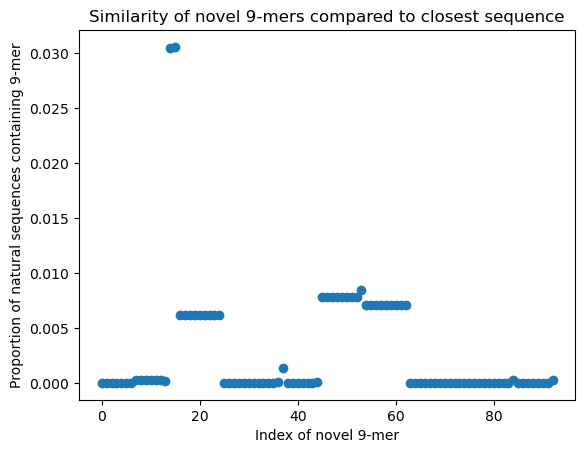

In [4]:
# Scatter plot indicating similarity of novel nu
plt.scatter(range(prob_of_9_mers_novel.shape[0]), prob_of_9_mers_novel)

plt.xlabel("Index of novel 9-mer")
plt.ylabel("Proportion of natural sequences containing 9-mer")
plt.title("Similarity of novel 9-mers compared to closest sequence")

plt.show()